In [1]:
# #To be used on cloud platforms

# ! python -c "import pykeen" || pip install pykeen
# ! python -c "import scprep" || pip install scprep

In [2]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt
import networkx, scprep, magic, torch, pykeen
import rpy2, rpy2.situation
from rpy2.robjects import r, pandas2ri

In [3]:
print(os.getcwd())
data_dir = f"{os.getcwd()}/data"
kge_dir = f"{os.getcwd()}/KGEs"

/Users/ferran/PhD/yaleCollab


Building a KG based on the NicheNet LigandReceptor-Signalling dataset (within their hosted weighted_networks.rds object).

The data is presented as weighted edges, so we can use the weights if using the graph directly or set a cutoff value if building a KG (unweighted).


# NicheNet KnowledgeGraph

## Constructing dKGnn

In [4]:
for i in rpy2.situation.iter_info(): # Print Rpy2 info
    print(i)

pandas2ri.activate()
%load_ext rpy2.ipython

rpy2 version:
3.5.1
Python version:
3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:01:00) 
[Clang 13.0.1 ]
Looking for R's HOME:
    Environment variable R_HOME: /Users/ferran/miniconda3/envs/collabLite/lib/R
    Calling `R RHOME`: /Users/ferran/miniconda3/envs/collabLite/lib/R
    Environment variable R_LIBS_USER: None
R's additions to LD_LIBRARY_PATH:
/usr/local/lib/R/library/stats/libs/:/usr/local/lib/R/library/stats/libs/
R version:
    In the PATH: R version 4.1.3 (2022-03-10) -- "One Push-Up"
    Loading R library from rpy2: OK
Additional directories to load R packages from:
None
C extension compilation:
  include:
  ['/Users/ferran/miniconda3/envs/collabLite/lib/R/include']
  libraries:
  ['R', 'pcre2-8', 'lzma', 'bz2', 'z', 'dl', 'm', 'iconv', 'icuuc', 'icui18n']
  library_dirs:
  ['/Users/ferran/miniconda3/envs/collabLite/lib', '/Users/ferran/miniconda3/envs/collabLite/lib/R/lib', '/Users/ferran/miniconda3/envs/collabLite/lib']
  extra_compile_args:
  []
  extra_lin

%%R -o dNNlr,dNNs,dNNgr
#Directly load RDS object from NicheNet's zenodo repo
dNNlr = readRDS(url("https://zenodo.org/record/3260758/files/lr_network.rds"))
dNNs = readRDS(url("https://zenodo.org/record/3260758/files/signaling_network.rds"))
dNNgr = readRDS(url("https://zenodo.org/record/3260758/files/gr_network.rds"))

print(dNNlr.describe())
print(dNNs.describe())
print(dNNgr.describe())

dNNlr = pd.DataFrame({
            "head":dNNlr["from"],
            "relation":np.repeat("LR", dNNlr.shape[0]),
            "tail":dNNlr["to"]
        })
dNNs = pd.DataFrame({
            "head":dNNs["from"],
            "relation":np.repeat("SIG", dNNs.shape[0]),
            "tail":dNNs["to"]
        })
dNNgr = pd.DataFrame({
            "head":dNNgr["from"],
            "relation":np.repeat("GR", dNNgr.shape[0]),
            "tail":dNNgr["to"]
        })

Load in pathway data from Ensembl2Reactome file. 
We will use this data to add new triples (named pathway) from REactome IDs to human gene symbols.

We're getting ensembl peptide IDs as we want to annotate human gene symbols that correspond to proteins.

from biomart import BiomartServer

#Load reactome database
dPathEnsR = pd.read_csv(f"{data_dir}/DBs/Ensembl2Reactome.txt", sep="\t", header=None)
dPathEnsR = dPathEnsR.loc[dPathEnsR[5]=="Homo sapiens"][[0,1]].drop_duplicates()

#Biomart section
server = BiomartServer("http://useast.ensembl.org/biomart")
server.verbose = True
mart = server.datasets["hsapiens_gene_ensembl"]
response = mart.search({"attributes":["ensembl_peptide_id","hgnc_symbol"]})
#Translation
transDF = []
for line in response.raw.data.decode("utf-8").splitlines():
    line = line.split("\t")
    if len(line[0]) > 0: #Only get gene symbols with ENSP ID
        transDF.append(line)
transDF = pd.DataFrame(transDF, 
                columns=["ensembl_peptide_id","hgnc_symbol"]
                ).drop_duplicates() 
transDict = transDF.set_index("ensembl_peptide_id"
                ).to_dict(
                    #Transform DF into a dictionary but first set index
                )["hgnc_symbol"]#Nested dict, so get first (and only item)

dPathEnsR[0] = dPathEnsR[0].map(transDict)
dPathEnsR = dPathEnsR.dropna().drop_duplicates()
dPathEnsR = pd.DataFrame({
            "head":dPathEnsR[1],
            "relation":np.repeat("pathway", dPathEnsR.shape[0]),
            "tail":dPathEnsR[0]
        })

### Make pathway metadata df

#Add in pathway metadata info: Dict with pathway name and Reactome PE IDs belonging to it
#Kepp in mind that not all of them are PTMs, some are just the protein
dPathMETA = pd.read_csv(f"{data_dir}/DBs/Ensembl2Reactome_PE_Pathway.txt", sep="\t", header=None)
dPathMETA = dPathMETA.loc[
    dPathMETA[7]=="Homo sapiens"][[1,2,3,5]].drop_duplicates().rename(
        columns = {1:"PE",2:"PE_name",3:"pathway",5:"pathway_name"})
dPathMETA = dPathMETA.loc[dPathMETA["pathway"].isin(dPathEnsR["head"])].reset_index(drop=True)
dPathMETA

In [5]:
# DEPRECATED CELL
# # print(len(dPathMETA["PE"].unique()))
# # print(len(dPathMETA["PE_name"].unique()))
# # print(len(dPathMETA["pathway"].unique()))
# # print(len(dPathMETA["pathway_name"].unique()))

# # df = dPathMETA[["pathway","pathway_name"]].drop_duplicates()

# # dPathMDdict = {}
# # for i in dPathMETA.iterrows():
# #     if i[1]["pathway"] not in dPathMDdict.keys():
# #         dPathMDdict[i[1]["pathway"]] = i[1]["pathway_name"]
# #         dPathMDdict["PEdict"] = {i[1]["PE"]:i[1]["PE_name"]}
# # print(dPathMDdict)

# # for name, group in dPathMETA.groupby(by="pathway"):
# #     print(name)
# #     print(group.to_dict("records"))

#### Save Pathway metadata

dPathMETA.to_csv(f"{data_dir}/dPathMETA.csv.tar.gz", index=False)

### Assemble triples dataset

Build final set of triples.
To make pykeen object, use from_labelled_triples() and load data columns of dKGnn as numpy and pass the metadata column (for pathways) as metadata arg.

#### Save dKGnn

dKGnn = pd.concat([dNNlr, dNNs, dNNgr, dPathEnsR]).drop_duplicates().reset_index(drop=True)
del dNNlr,dNNs,dNNgr,dPathEnsR
dKGnn

dKGnn.to_csv(f"{data_dir}/dKGnn.csv.tar.gz", index=False, header=False)

## LOAD dKGnn and metadata

Load dKGnn

In [6]:
dKGnn = pd.read_csv(f"{data_dir}/dKGnn.csv.tar.gz", header=None)
dKGnn

,0,1,2
0,CXCL1,LR,CXCR2
1,CXCL2,LR,CXCR2
2,CXCL3,LR,CXCR2
3,CXCL5,LR,CXCR2
4,PPBP,LR,CXCR2
...,...,...,...
5444497,R-HSA-6798695,pathway,SIGLEC5
5444498,R-HSA-1181150,pathway,TDGF1P3
5444499,R-HSA-1433617,pathway,TDGF1P3
5444500,R-HSA-3295583,pathway,TRPM5


Load pathway metadata

In [7]:
dPathMETA = pd.read_csv(f"{data_dir}/dPathMETA.csv.tar.gz")
dPathMETA

,PE,PE_name,pathway,pathway_name
0,R-HSA-162865,DPM1 [endoplasmic reticulum membrane],R-HSA-162699,Synthesis of dolichyl-phosphate mannose
1,R-HSA-4717383,DPM1 G111Lfs*45 [endoplasmic reticulum membrane],R-HSA-4717374,Defective DPM1 causes DPM1-CDG
2,R-HSA-4717361,DPM1 Q210Rfs*4 [endoplasmic reticulum membrane],R-HSA-4717374,Defective DPM1 causes DPM1-CDG
3,R-HSA-4717370,DPM1 R92G [endoplasmic reticulum membrane],R-HSA-4717374,Defective DPM1 causes DPM1-CDG
4,R-HSA-162865,DPM1 [endoplasmic reticulum membrane],R-HSA-4719360,Defective DPM3 causes DPM3-CDG
...,...,...,...,...
71351,R-HSA-3209107,p14ARF mRNA [cytosol],R-HSA-8951936,RUNX3 regulates p14-ARF
71352,R-HSA-8848195,U4atac snRNA [nucleoplasm],R-HSA-6807505,RNA polymerase II transcribes snRNA genes
71353,R-HSA-8848195,U4atac snRNA [nucleoplasm],R-HSA-72165,mRNA Splicing - Minor Pathway
71354,R-HSA-428380,MYC mRNA [cytosol],R-HSA-428359,Insulin-like Growth Factor-2 mRNA Binding Prot...


## KGnn graph metrics

In [8]:
G = networkx.from_pandas_edgelist(dKGnn,source=0,target=2,edge_attr=1)

print(f"{networkx.info(G)}, with a density of {networkx.density(G)}")
print("We have this many isolates: ", 
      networkx.number_of_isolates(G))
print("The graph is connected:",
     networkx.is_connected(G))

if not networkx.is_connected(G):
    print(f"\nWe have {networkx.number_connected_components(G)} connected subgraphs")
    
    Gcomponents = [G.subgraph(c).copy() for c in networkx.connected_components(G)]
    for i,g in enumerate(Gcomponents,start=1):
        print(f"Component {i}: {networkx.info(g)}, with a density of {networkx.density(g)}")

/var/folders/9p/ypn2045x1cxbq9ptcfk4_k7m0000gn/T/ipykernel_32990/1248142686.py:3: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(f"{networkx.info(G)}, with a density of {networkx.density(G)}")


Graph with 27620 nodes and 4258252 edges, with a density of 0.011164254560457875
We have this many isolates:  0
The graph is connected: True


networkx.draw(G)

# KGEmbedding

## Build the KGE

In [9]:
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory

tf = TriplesFactory.from_labeled_triples(
        dKGnn.to_numpy(dtype="str"),create_inverse_triples=False)
tf

import json
with open(f"{data_dir}/dKGnn_entityIDS.json","w") as outf:
    json.dump(tf.entity_id_to_label, outf)

Compute with default model:

In [11]:
modelKGE = "KGnn_50_unstratified_stopped_transe"

%%time

training, testing, validation = tf.split([.8, .1, .1])

result = pipeline(
    training=training,
    testing=testing,
    validation=validation,
    model="TransE",
    model_kwargs=dict(embedding_dim=50),
    training_loop='sLCWA',
    negative_sampler='basic',
    stopper="early",
    random_seed=42,
    epochs=10,  # short epochs for testing - you should go
                # higher, especially with early stopper enabled
                
)

# result.save_to_directory(f"{kge_dir}/one50_unstratified_stopped_transe")
result.save_to_directory(f"{kge_dir}/{modelKGE}")

#model used TransE has only one representation for entities and relations, 
# so modules objects will be of length 1
print(result.model)
result.plot_losses()
# result.plot_early_stopping()

## Load built model and explore

In [12]:
try:
    trained_model = torch.load(f"{kge_dir}/{modelKGE}/trained_model.pkl")
except RuntimeError:
    trained_model = torch.load(f"{kge_dir}/{modelKGE}/trained_model.pkl",
    map_location=torch.device("cpu"))

trained_model

TransE(
  (loss): MarginRankingLoss(
    (margin_activation): ReLU()
  )
  (interaction): TransEInteraction()
  (entity_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(27620, 50)
    )
  )
  (relation_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(4, 50)
    )
  )
  (weight_regularizers): ModuleList()
)

In [13]:
#Construct nodes dataframe: detach() for now is meaningless as compute is CPU
entity_embeddings = trained_model.entity_representations[0](indices=None).detach().cpu().numpy()

import json
with open(f"{data_dir}/dKGnn_entityIDS.json") as infile:
    entityIDS = json.load(infile)
dKGEnn_50 = pd.DataFrame(entity_embeddings, index=entityIDS.values())
dKGEnn_50

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
A1BG,-0.114693,-0.062056,-0.142618,-0.018786,0.079787,0.151638,0.154332,-0.166625,-0.164315,0.150550,...,0.110171,0.162007,0.136376,0.098658,0.172536,0.010266,-0.002167,0.260938,-0.156283,0.223170
A1BG-AS1,0.124340,-0.244321,0.261028,0.177759,0.052111,-0.206777,-0.068553,0.004152,-0.151796,0.048616,...,0.026584,-0.064389,0.186161,0.029930,0.043194,-0.230858,0.020652,-0.079490,-0.100852,-0.110040
A1CF,0.012249,0.097411,0.089748,-0.107028,0.042079,-0.015802,-0.015080,-0.035531,-0.108423,0.396735,...,0.109560,-0.146671,0.138407,0.118278,-0.090030,-0.198067,-0.064056,0.112160,-0.157560,0.070585
A2M,-0.076020,0.167864,-0.133910,-0.082698,0.086467,-0.096204,-0.068033,-0.012295,-0.197465,-0.067780,...,0.217745,0.121485,-0.044373,0.006619,0.188977,-0.075680,-0.122628,0.149013,-0.203135,0.045033
A2M-AS1,-0.124042,-0.071744,0.190024,0.210376,-0.199619,-0.146263,-0.201290,-0.032545,-0.092695,0.039749,...,-0.011503,0.263200,-0.154127,0.032356,-0.221216,-0.127091,-0.050592,-0.162741,0.066823,0.046689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11B,0.154281,0.013954,-0.161645,-0.170701,0.077110,0.007194,0.163640,0.013357,0.084101,-0.117073,...,0.051953,-0.137357,-0.201208,0.120000,-0.147011,0.176326,-0.140640,0.019583,-0.134760,-0.269244
ZYX,0.168261,0.047865,-0.021720,-0.076904,-0.110663,0.096434,0.134658,-0.113244,0.069367,0.069998,...,0.089988,-0.037320,-0.318342,0.089743,0.215972,0.183160,-0.249219,0.011088,0.176135,-0.244414
ZZEF1,-0.587509,0.074710,-0.146124,0.098394,-0.006699,0.052911,-0.004144,-0.310832,0.171271,0.067289,...,-0.024145,0.191872,0.026109,0.103047,0.075540,0.109647,0.108737,-0.114406,-0.031095,-0.060478
ZZZ3,0.082273,-0.122881,-0.079879,-0.102180,0.182568,-0.098044,0.037568,0.169248,0.135375,0.008222,...,-0.317155,0.172255,-0.062920,-0.214967,-0.019557,0.112612,0.041938,-0.038473,0.204341,0.047962


### PCA

/Users/ferran/miniconda3/envs/collabLite/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


,0,1
A1BG,-0.519948,0.091524
A1BG-AS1,0.337495,-0.250680
A1CF,-0.085869,0.014344
A2M,-0.442316,0.009512
A2M-AS1,0.492611,0.034598
...,...,...
ZYG11B,-0.312054,-0.138608
ZYX,-0.574332,0.462840
ZZEF1,-0.302417,-0.007610
ZZZ3,-0.240059,-0.087890


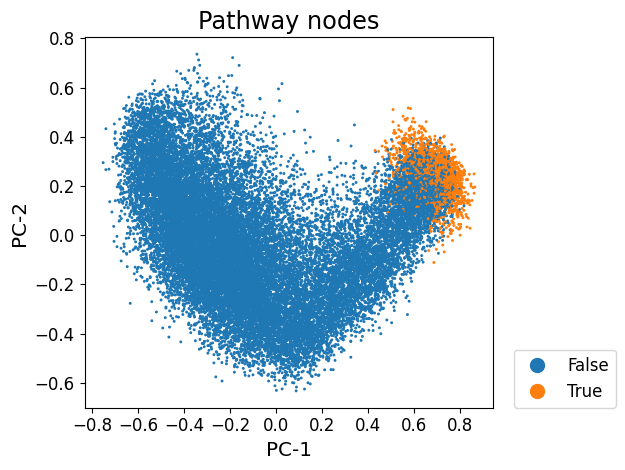

In [14]:
from sklearn.decomposition import PCA

dKGEnn_pca = PCA(n_components=2).fit_transform(dKGEnn_50)
dKGEnn_pca = pd.DataFrame(dKGEnn_pca, index=entityIDS.values())

scprep.plot.scatter2d(dKGEnn_pca, 
    c=dKGEnn_pca.index.isin(dPathMETA["pathway"]), 
    title="Pathway nodes", label_prefix="PC-", 
    legend_loc=(1.05, 0), shuffle=True,
    dpi=480)

dKGEnn_pca

### Clustering

For n_clusters = 2 The average silhouette_score is : 0.12752241
For n_clusters = 3 The average silhouette_score is : 0.097642116
For n_clusters = 4 The average silhouette_score is : 0.09129457
For n_clusters = 5 The average silhouette_score is : 0.08215945
For n_clusters = 6 The average silhouette_score is : 0.084912516
For n_clusters = 8 The average silhouette_score is : 0.07191191


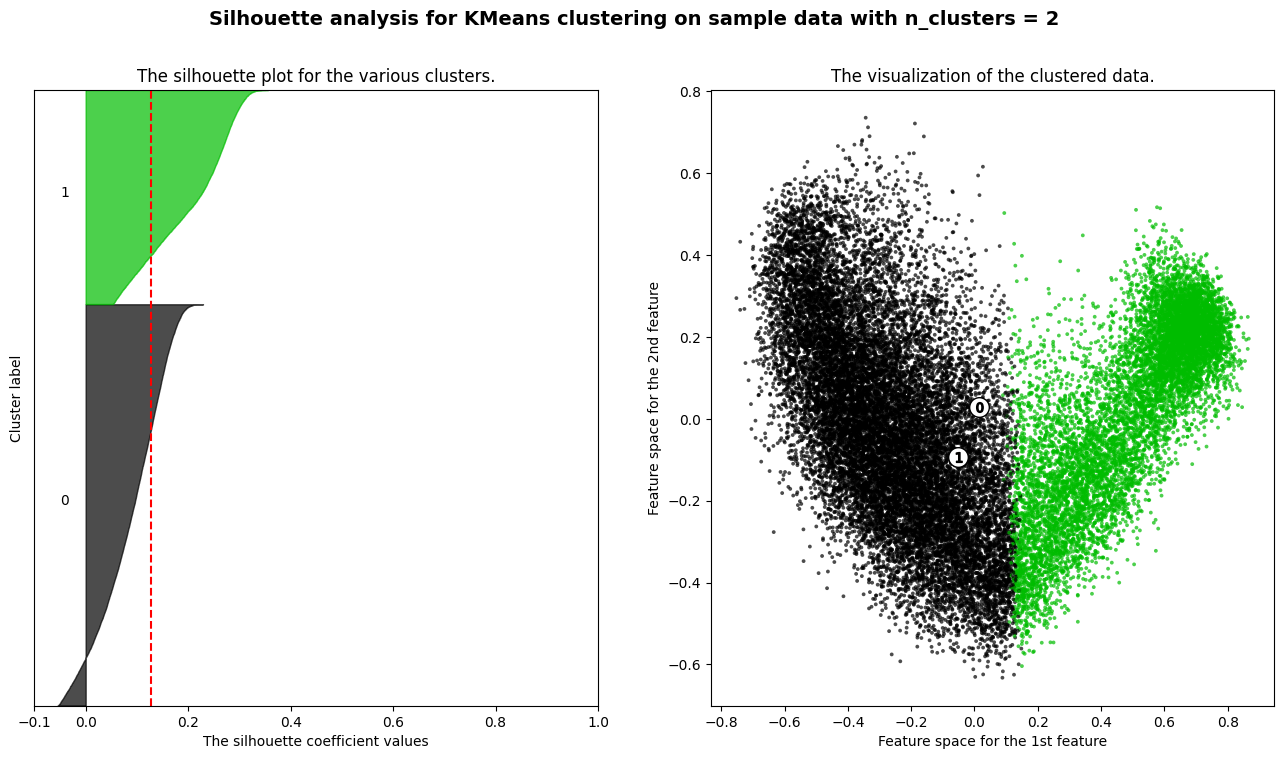

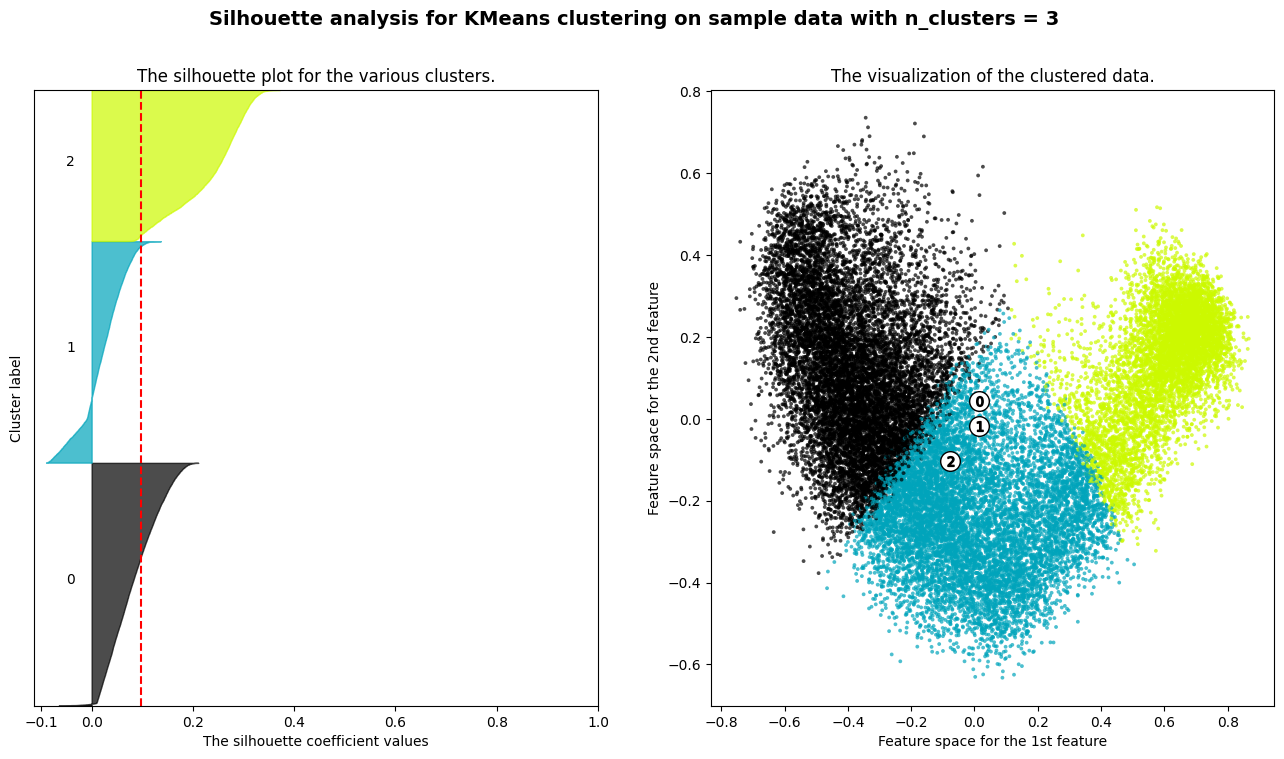

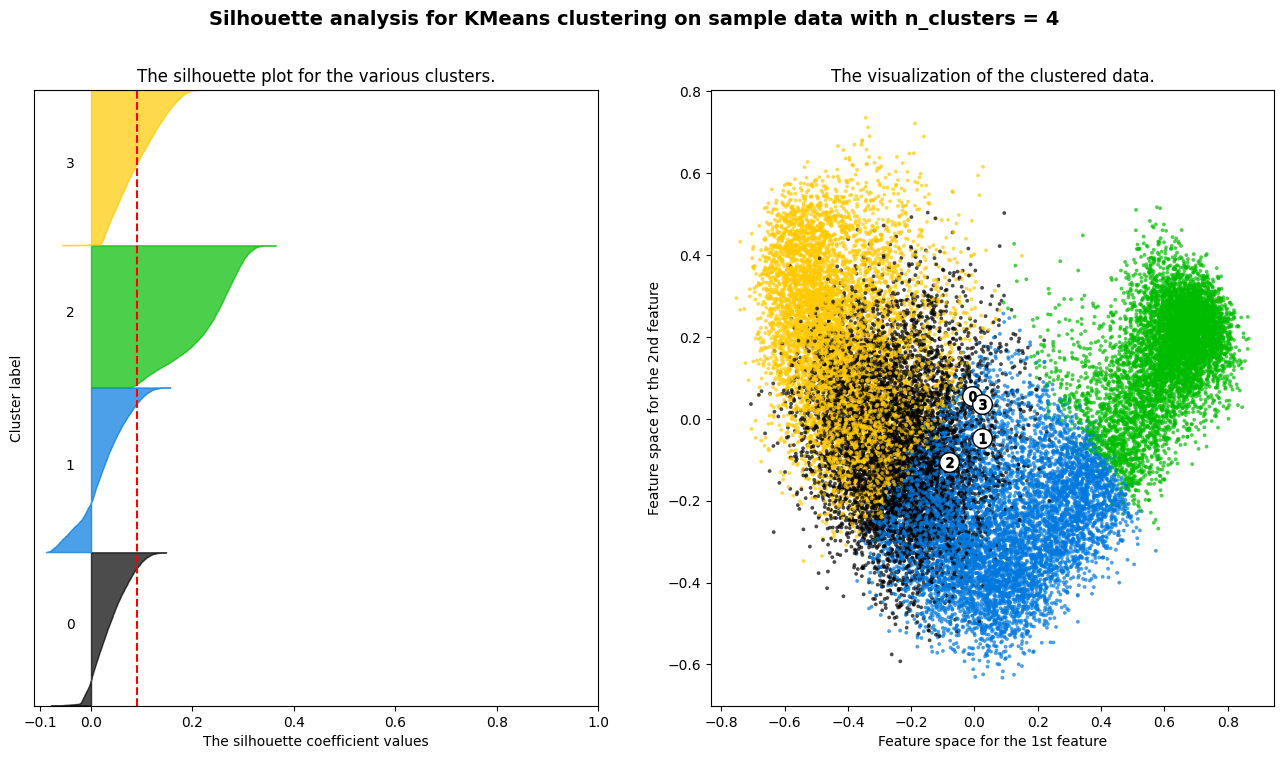

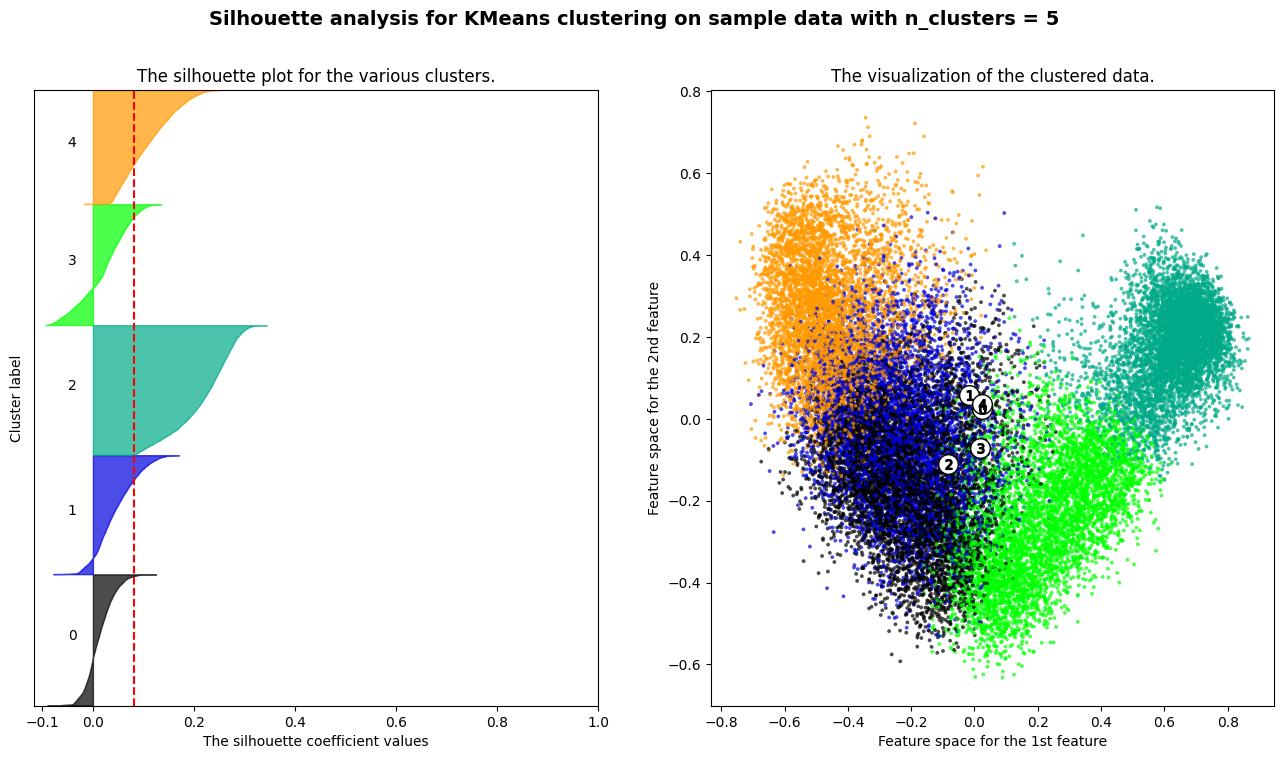

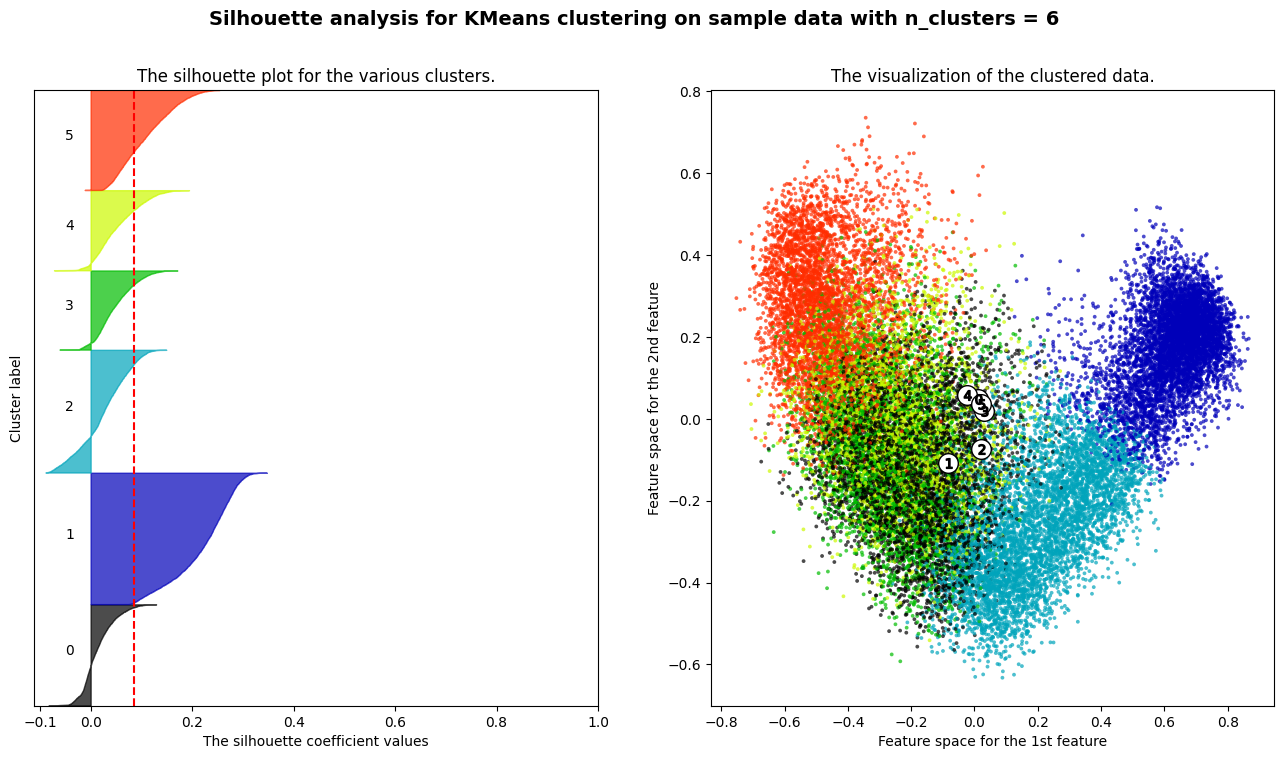

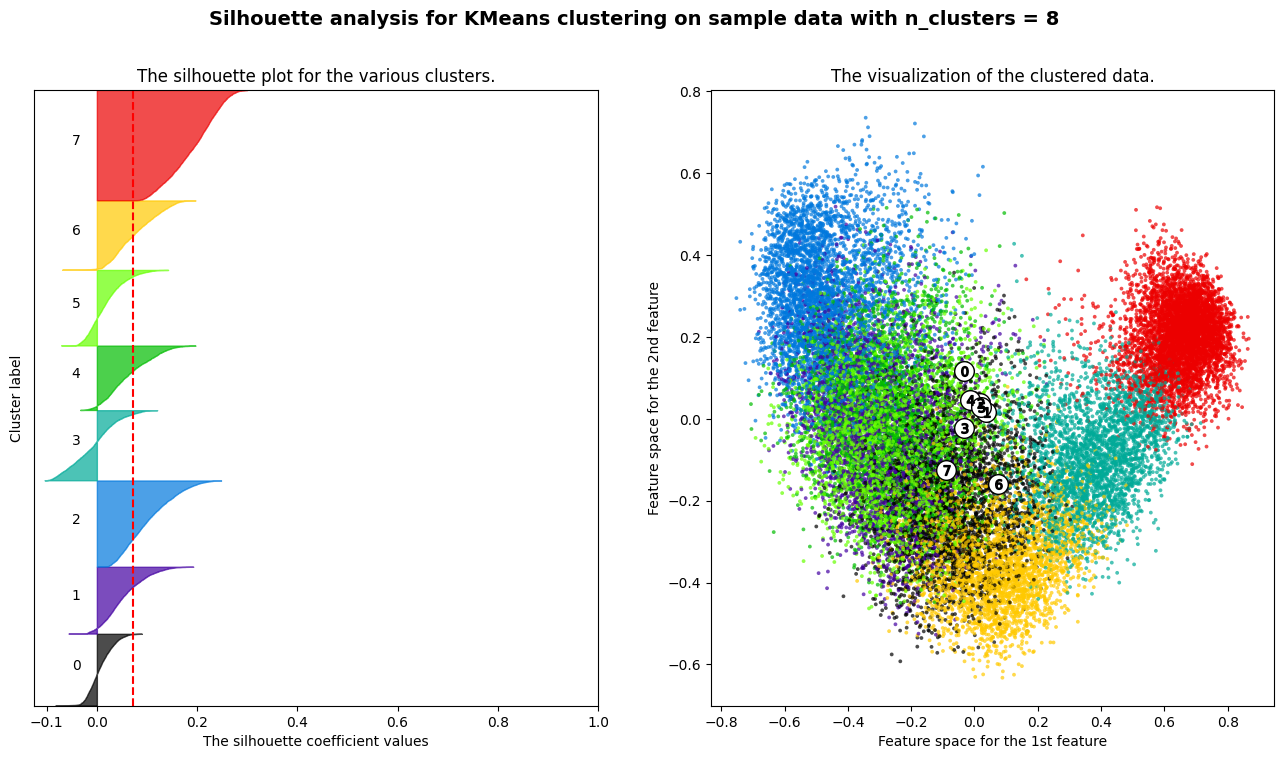

In [15]:
#Snippet from scikit-learn docs

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score


#Remove NA from first missing genesymbol row in dKGE:
dKGEnn_50 = dKGEnn_50.dropna()
dKGEnn_pca = dKGEnn_pca.dropna()

range_clust = [2,3,4,5,6,8]

for n_clusters in range_clust:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(16, 8)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 
    # # but in this example all
    # # lie within [-0.1, 1]
    # ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(dKGEnn_50) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 12 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=12)
    cluster_labels = clusterer.fit_predict(dKGEnn_50)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(dKGEnn_50, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(dKGEnn_50, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        dKGEnn_pca[0], dKGEnn_pca[1], 
        marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()